# Deep learning and Dogs vs. Cats - Part 2... Now with Convolutions!
##  Data set https://www.kaggle.com/c/dogs-vs-cats
(the data set should be installed in two directories just above the one where this notebook is located: train and test1)
#### Based on https://github.com/fchollet/keras/blob/master/examples/mnist_cnn.py and http://cs231n.github.io/convolutional-networks/

### http://ricardodeazambuja.com/deep_learning/2017/03/05/easy-peasy_conv_deep_learning_two/

In [2]:
# The package 'os' will be necessary to find the current
# working directory os.getcwd() and also to list all
# files in a directory os.listdir().
import os

# https://docs.python.org/2/library/multiprocessing.html
from multiprocessing import Pool

# Only used for the final test
import urllib, cStringIO

# Yep, I don't like to import numpy as np :P
import numpy

# As I've explained somewhere, Scipy will help us
# reading (using Pillow) and resizing images.
import scipy.misc

# SOMETHING NEW HERE!!!
# For our convolution playground
from scipy.signal import convolve2d

# Pyplot is what we use for plotting
import matplotlib.pyplot as plt

# Only for the 2D convolution video
import matplotlib.patches as patches


# And here is the Keras stuff:

# We don't really need this since it would 
# be easy do code something like this ourselves
from keras.utils import np_utils

# https://keras.io/getting-started/sequential-model-guide/
from keras.models import Sequential

# For visualization of what is happening inside
# http://ricardodeazambuja.com/deep_learning/2017/02/12/easy-peasy_deep_learning_one_and_a_half/
from keras.models import Model

from keras.layers import Dense
from keras.layers import Activation
from keras.layers import Dropout


# SOMETHING NEW HERE!!!
# Things we will need for our CNN
from keras.layers import Convolution2D, MaxPooling2D, Flatten


# https://keras.io/optimizers/
from keras.optimizers import SGD
from keras.optimizers import Adagrad 

# While the method for saving a model is
# part of the model object, to load we need
# to import something else
from keras.models import load_model

## 1) Load the data sets

In [3]:
# Returns the current working directory
# (where the Python interpreter was called)
path = os.getcwd()

# The path separator used by the OS:
sep = os.path.sep

# This is the directory where the training images are located
dirname = "train"

# Generates a list of all images (actualy the filenames) from the training set,
# but it will also include the full path
imagePaths = [path+sep+dirname+sep+filename 
                  for filename in os.listdir(path+sep+dirname)]

In [4]:
# To speed up things, I will use parallel computing!
# Pool lets me use its map method and select the number of parallel processes.

def import_training_set(args):
    '''
    Reads the image from imagePath, resizes 
    and returns it together with its label and 
    original index.

    '''
    index,imagePath,new_image_size = args

    # Reads the image
    image = scipy.misc.imread(imagePath)

    # Split will literally split a string at that character
    # returning a list of strings.
    # First we split according to the os.path.sep and keep 
    # only the last item from the list gererated ([-1]).
    # This will give us the filename. 
    filename = imagePath.split(os.path.sep)[-1]
    
    # Then we split it again using "."  
    # and extract the first item ([0]):
    label = filename.split(".")[0]
    
    # and the second item ([1]):
    original_index = filename.split(".")[1]

    # SOMETHING NEW HERE!!!
    # Resizes the image (downsampling) to new_image_size
    input_image = scipy.misc.imresize(image,new_image_size)
    # Do exactly what it says: put the last axis on the first position.
    # https://docs.scipy.org/doc/numpy/reference/generated/numpy.rollaxis.html
    input_image = numpy.rollaxis(input_image, 2, 0)

    # SOMETHING NEW HERE!!!
    return (index,(original_index,label,input_image))

In [5]:
%%time
# The size of the resized image.
# After we apply the flatten method, it will become a list of 32x32x3 items (1024x3).
# (Where is the 'x3' coming from? Our images are composed of three colors!)
new_image_size = 32,32

number_of_parallel_processes = 7

# When the map is finished, we will receive a list with tuples:
# (index,(original_index,label,input_vector)) => (index,(original_index,'category',1D resized image))
#
# There's no guarantee about the ordering because they are running in parallel.
ans = Pool(number_of_parallel_processes).map(import_training_set,[(i,img,new_image_size) 
                                                                  for i,img in enumerate(imagePaths)])

CPU times: user 232 ms, sys: 96 ms, total: 328 ms
Wall time: 37.5 s


In [6]:
# Because import_training_set returns a tuple like this:
# (index,(original_index,label,input_vector))
# and index is unique, we can convert to a dictionary
# to solve our problem with unordered items:
training_set = dict(ans)

# Gives a hint to the garbage collector...
del ans

In [7]:
# Let's verify if we loaded all images:
len(training_set)

25000

In [9]:
# I've never tried Keras with TensorFlow, but, as I understood, it will 
# need to be changed to a shape (32,32,3)
training_set[0][2].shape

(3, 32, 32)

## Let's load one image from training set to test some classic kernels using Scipy convolve2D

In [10]:
cat_img = scipy.misc.imread(path+sep+dirname+"/cat.666.jpg")/255. # /255. normalises (0 to 1)

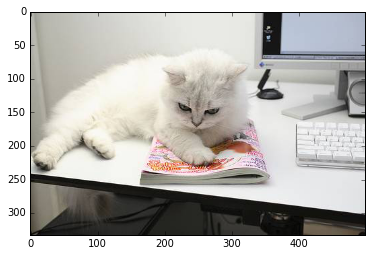

In [11]:
plt.imshow(cat_img)
plt.show()

In [12]:
# Some kernels from:
# https://en.wikipedia.org/wiki/Kernel_(image_processing)
# Indentity
kernel_id = [
             [0, 0, 0],
             [0, 1, 0],
             [0, 0, 0]
             ]
kernel_id = numpy.array(kernel_id,dtype=float)

# Edge detector
kernel_edge = [
             [ 1, 0, -1],
             [ 0, 0,  0],
             [-1, 0,  1]
             ]
kernel_edge = numpy.array(kernel_edge,dtype=float)

# Blur
kernel_blur = [
             [1, 1, 1],
             [1, 1, 1],
             [1, 1, 1]
             ]
kernel_blur = numpy.array(kernel_blur,dtype=float)
kernel_blur /= kernel_blur.sum() # normalises

In [13]:
cat_img.shape

(333, 499, 3)

In [14]:
# First uses the indentity kernel 
# (should keep the same image, since it's full of zeros and with one at the centre)
cat_img_conv_id = numpy.zeros(cat_img.shape)
for i in range(3):
    cat_img_conv_id[:,:,i] = convolve2d(cat_img[:,:,i],kernel_id,
                                        mode='same',
                                        boundary='wrap')
    

# http://stackoverflow.com/a/12201744/7658422
# Simple way to convert to grayscale:
cat_img_gray = numpy.dot(cat_img[...,:3], [0.299, 0.587, 0.114])

# Now uses the edge detection (the image was converted to grayscale)
cat_img_conv_edge = convolve2d(cat_img_gray,kernel_edge,
                               mode='same',
                               boundary='wrap')

# Blur or loss-pass filter
cat_img_conv_blur = numpy.zeros(cat_img.shape)
for i in range(3):
    cat_img_conv_blur[:,:,i] = convolve2d(cat_img[:,:,i],kernel_blur,
                                          mode='same',
                                          boundary='wrap')

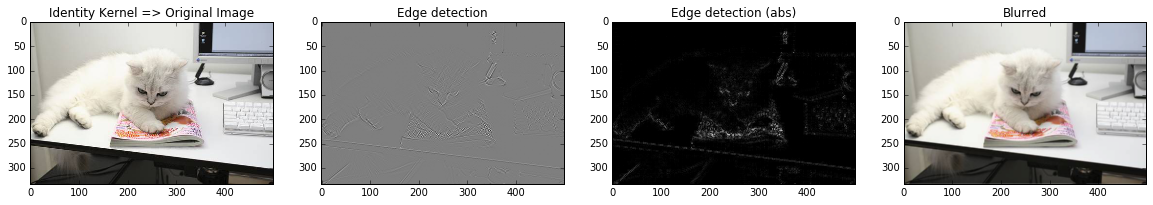

In [15]:
plt.figure(figsize=(20,10))
plt.subplot(141)
plt.imshow(cat_img_conv_id)
plt.title("Identity Kernel => Original Image")

plt.subplot(142)
plt.imshow(cat_img_conv_edge,cmap='gray')
plt.title("Edge detection")

plt.subplot(143)
plt.imshow(numpy.abs(cat_img_conv_edge),cmap='gray')
plt.title("Edge detection (abs)")


plt.subplot(144)
plt.imshow(cat_img_conv_blur)
plt.title("Blurred")
plt.show()

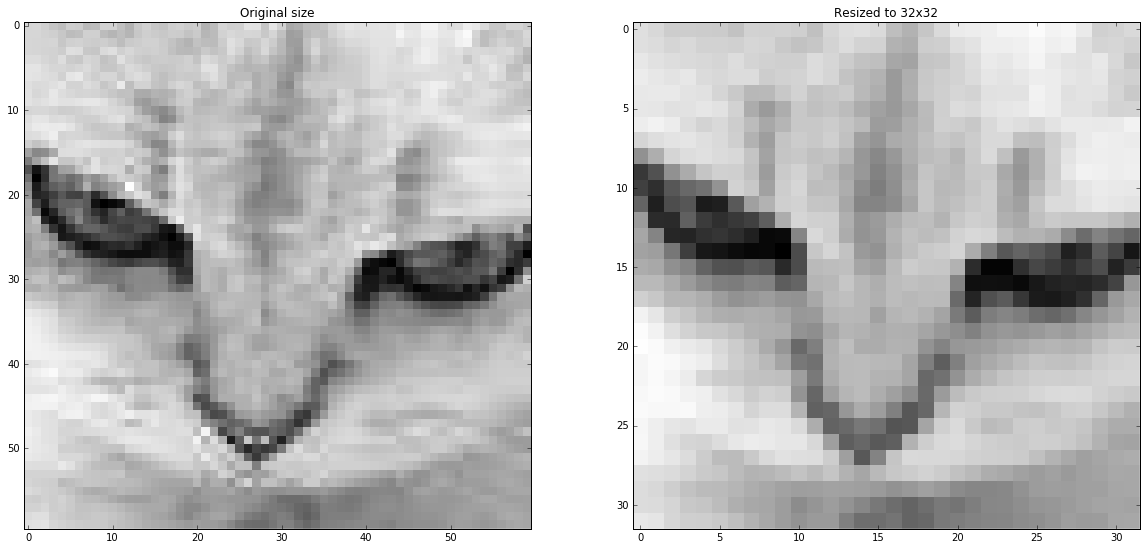

In [16]:
# Now, let's get only the cat's face:
cat_face_gray_small = cat_img_gray[120:180,220:280]

plt.figure(figsize=(20,10))
plt.subplot(121)
plt.imshow(cat_face_gray_small,interpolation='none',cmap='gray')
plt.title("Original size")
plt.subplot(122)
plt.imshow(scipy.misc.imresize(cat_face_gray_small,(32,32)),interpolation='none',cmap='gray')
plt.title("Resized to 32x32")
plt.show()

In [17]:
def my_patch(x, y, size, alpha_in=0.3, color_in='red'):
    assert size%2==1, "size must be an odd number!"
    # http://matthiaseisen.com/pp/patterns/p0203/
    return patches.Rectangle((x-(size/2+1)+0.5, y-(size/2+1)+0.5), size, size, alpha=alpha_in, color=color_in)

In [18]:
# 
# We will apply the edge detector kernel, manually instead of using scipy
# 

kernel_size = 3
kernel_centre = (int(kernel_size/2)+1)
img_resized = (32,32)

# Here I'm zero padding the original image
cat_face_gray_smaller = numpy.zeros((img_resized[0]+kernel_centre,
                                     img_resized[1]+kernel_centre),
                                     dtype=float)
cat_face_gray_smaller[kernel_centre/2:-kernel_centre/2,
                      kernel_centre/2:-kernel_centre/2] = scipy.misc.imresize(cat_face_gray_small,
                                                                              img_resized)/255.

# This will store the result of our 2D convolution
img_conv_result = numpy.zeros(img_resized, dtype=float)

if not os.path.exists("animation"):
    os.makedirs("animation")
x,y=0,0

for x in range(img_resized[0]):
    for y in range(img_resized[1]):
        img_conv_result[y,x]=(cat_face_gray_smaller[y:y+kernel_size,x:x+kernel_size]*kernel_edge).sum()

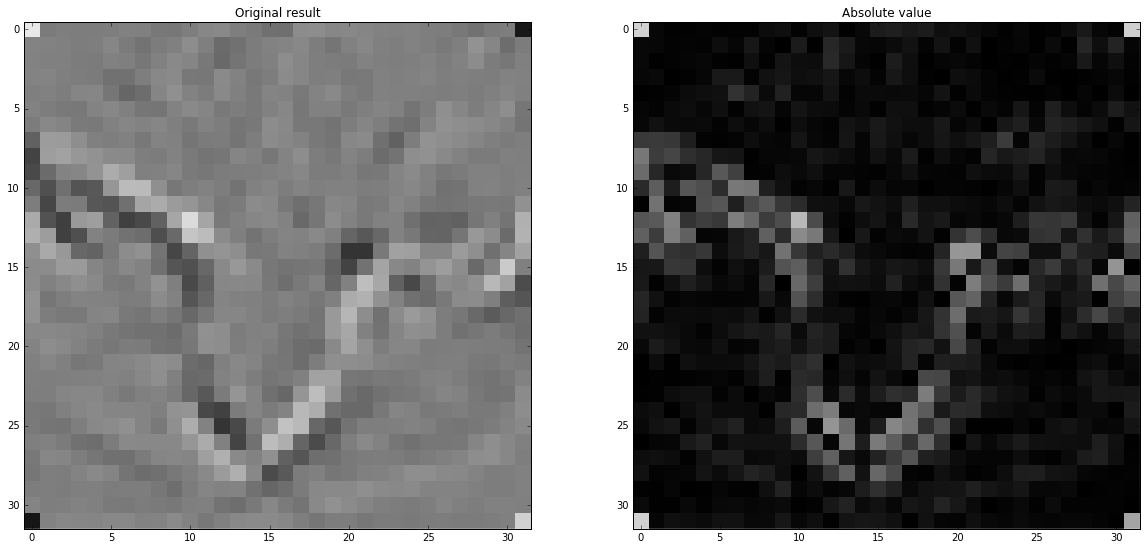

In [19]:
plt.figure(figsize=(20,10))
plt.subplot(121)
plt.imshow(img_conv_result,interpolation='none',cmap='gray', vmin=-1, vmax=1)
plt.title("Original result")
plt.subplot(122)
plt.imshow(abs(img_conv_result),interpolation='none',cmap='gray', vmin=0, vmax=1)
plt.title("Absolute value")
plt.show()

In [162]:
%%time
img_conv_result_fig = numpy.ones(img_conv_result.shape,dtype=float)
# Generate the images
for x in range(img_resized[0]):
    for y in range(img_resized[1]):
        x_visual = x + kernel_centre/2
        y_visual = y + kernel_centre/2

        plt.figure(figsize=(20,10))
        plt.suptitle("http://ricardodeazambuja.com", fontsize=15)
        plt.subplot2grid((3,6), (0, 0), colspan=3, rowspan=2)
        plt.imshow(cat_face_gray_smaller,interpolation='none',cmap='gray',
                   vmin=0, vmax=1)
        ax = plt.gca()
        ax.add_patch(my_patch(x_visual,y_visual,kernel_size))
        plt.scatter(x_visual, y_visual, color='red')
        plt.xlim(-0.5,img_resized[0]+kernel_centre-0.5)
        plt.ylim(img_resized[0]+kernel_centre-0.5,-0.5)
        plt.title("Original zero padded image")

        plt.subplot2grid((3,6), (0, 3), colspan=3, rowspan=2)
        img_conv_result_fig[y,x] = img_conv_result[y,x]
        plt.imshow(img_conv_result_fig,interpolation='none',cmap='gray',
                   vmin=0, vmax=1)
        # plt.scatter(x, y, color='red',marker='s', s=100, alpha=0.5)
        plt.xlim(-0.5,img_resized[0]-0.5)
        plt.ylim(img_resized[0]-0.5,-0.5)
        plt.title("Result of the convolution")
        plt.colorbar()

        plt.subplot2grid((3,6), (2, 2), colspan=2)
        plt.imshow(cat_face_gray_smaller[y:y+kernel_size,x:x+kernel_size]*kernel_edge,interpolation='none',cmap='gray',
                   vmin=-1, vmax=1)
        plt.colorbar()
        plt.title("Result of kernel x current image patch")
        plt.tight_layout(pad=0, h_pad=0, w_pad=1, rect=None)
        plt.savefig('animation/ConvAnimation_'+str(x)+'_'+str(y)+'_.png', bbox_inches='tight',pad_inches=0.1)#, dpi=300)        
        
        plt.close()
#         plt.show()

CPU times: user 18min 55s, sys: 16.6 s, total: 19min 12s
Wall time: 19min 14s


The final animation is a mix between these two ideas:  
http://stackoverflow.com/a/28015795/7658422  
and  
http://stackoverflow.com/a/14666689/7658422

See the notebook:  
Matplotlib Animation on Jupyter.ipynb

## Now we know a little bit more about convolutions, let's get back to Keras!

## 2) Prepare the data set for Keras

A lot of things are just repetition from the previous posts...

In [20]:
# Let's imagine we don't know how many different labels we have.
# (we know, they are 'cat' and 'dog'...)
# A Python set can help us to create a list of unique labels.
# (i[0]=>filename index, i[1]=>label, i[2]=>1D vector)
unique_labels = set([i[1] for i in training_set.values()])

# With a list of unique labels, we will generate a dictionary
# to convert from a label (string) to a index (integer):
labels2int = {j:i for i,j in enumerate(unique_labels)}


# Creates a list with labels (ordered according to the dictionary index)
labels = [labels2int[i[1]] for i in training_set.values()]

In [21]:
# Instead of '1' and '0', the function below will transform our labels
# into vectors [0.,1.] and [1.,0.]:
labels = np_utils.to_categorical(labels, 2)

In [22]:
# First, we will create a numpy array going from zero to len(training_set):
# (dtype=int guarantees they are integers)
random_selection = numpy.arange(len(training_set),dtype=int)

# Then we create a random state object with our seed:
# (the seed is useful to be able to reproduce our experiment later)
seed = 12345
rnd = numpy.random.RandomState(seed)

# Finally we shuffle the random_selection array:
rnd.shuffle(random_selection)

In [23]:
test_size=0.25 # we will use 25% for testing purposes

# Breaking the code below to make it easier to understand:
# => training_set[i][-1]
# Returns the 1D vector from item 'i'.
# => training_set[i][-1]/255.0
# Normalizes the input values from 0. to 1.
# => random_selection[:int(len(training_set)*(1-test_size))]
# Gives us the first (1-test_size)*100% of the shuffled items
trainData = [training_set[i][-1]/255.0 for i in random_selection[:int(len(training_set)*(1-test_size))]]
trainData = numpy.array(trainData)

trainLabels = [labels[i] for i in random_selection[:int(len(training_set)*(1-test_size))]]
trainLabels = numpy.array(trainLabels)

testData = [training_set[i][-1]/255.0 for i in random_selection[:int(len(training_set)*(test_size))]]
testData = numpy.array(testData)

testLabels = [labels[i] for i in random_selection[:int(len(training_set)*(test_size))]]
testLabels = numpy.array(testLabels)

## Here we are going to make changes to transform our ANN into a CNN!

## 3) Create the Sequential model
Now our model will start with a Convolution2D layer:  
https://keras.io/layers/convolutional/#convolution2d  
Convolution2D(nb_filter, nb_row, nb_col, init='glorot_uniform', activation=None, weights=None, border_mode='valid', subsample=(1, 1), dim_ordering='default', W_regularizer=None, b_regularizer=None, activity_regularizer=None, W_constraint=None, b_constraint=None, bias=True)

And apply MaxPooling2D (it's a pool layer that uses the maximum value):  
https://keras.io/layers/pooling/#maxpooling2d  
http://cs231n.github.io/convolutional-networks/#pool

In [28]:
# input layer shape (now it's made of three matrices instead of 1D vectors)
input_layer_shape = (3,new_image_size[0], new_image_size[1]) # We use '3' because it's a RGB image.

# number of convolutional filters to use
number_of_filters = 32
# convolution kernel size
kernel_size = (3, 3)
# size of pooling area for max pooling
pool_size = (2, 2)

# I MUST EXPLAIN HERE I'VE ADDED ANOTHER LAYER WHEN COMPARED WITH THE FIRST NETWORK.

In [177]:
use_dropout = True
dropout_perc = 0.3

# https://keras.io/getting-started/sequential-model-guide/
# define the architecture of the network
model = Sequential()


# SOMETHING NEW HERE!!!
# INPUT LAYER
# Now this is our input layer. It will receive the image without making it flat as we did.
# https://keras.io/layers/convolutional/#convolution2d
model.add(Convolution2D(number_of_filters, 
                        kernel_size[0], 
                        kernel_size[1],
                        border_mode='same', # keeps the output the same shape as the input
                        input_shape=input_layer_shape,
                        name='ConvLayer1'))

# The output's shape of the Convolution2D is (None,nb_filters,input_layer_shape[1], input_layer_shape[2]

model.add(Activation('relu', 
                     name='ConvLayer1Activation'))

# https://keras.io/layers/pooling/#maxpooling2d
model.add(MaxPooling2D(pool_size=pool_size,
                       dim_ordering='th', # 'th'=>because I'm using Theano
                       name='PoolingLayer1')) 

# After MaxPooling2D, the outputs will be shrinked by pool_size (see Keras help link above...)

# https://keras.io/layers/core/#dropout
if use_dropout: 
    model.add(Dropout(dropout_perc))
    
# SOMETHING NEW HERE!!!
# SECOND CONV LAYER
# Now this is our input layer. It will receive the image without making it flat as we did.
# https://keras.io/layers/convolutional/#convolution2d
model.add(Convolution2D(8,#number_of_filters, 
                        kernel_size[0], 
                        kernel_size[1],
                        border_mode='same', # keeps the output the same shape as the input
                        name='ConvLayer2'))

# The output's shape of the Convolution2D is (None,nb_filters,input_layer_shape[1], input_layer_shape[2]

model.add(Activation('relu', 
                     name='ConvLayer2Activation'))

# https://keras.io/layers/pooling/#maxpooling2d
model.add(MaxPooling2D(pool_size=pool_size,
                       dim_ordering='th', # 'th'=>because I'm using Theano
                       name='PoolingLayer2')) 

# https://keras.io/layers/core/#dropout
if use_dropout: 
    model.add(Dropout(dropout_perc))


# Transforms into 1D
model.add(Flatten())


# A Dense layer is a fully connected NN layer (feedforward)
# https://keras.io/layers/core/#dense
# Input size is automatic
dense_output_size = 128
model.add(Dense(dense_output_size, 
                init="uniform",
                name='HiddenLayer'))

model.add(Activation('relu',
                     name='HiddenLayerActivation'))

if use_dropout: 
    model.add(Dropout(dropout_perc))


# Because we want to classify between only two classes (binary), the final output is 2
model.add(Dense(2))
model.add(Activation("softmax"))

# I WANT TO VISUALIZE WHAT THE NETWORK IS GENERATING AFTER THE CONVOLUTION AND AFTER THE POOLING

In [178]:
# https://keras.io/getting-started/faq/#how-can-i-obtain-the-output-of-an-intermediate-layer

intermediate_layer_names = ['ConvLayer1','ConvLayer1Activation','PoolingLayer1',
                            'ConvLayer2','ConvLayer2Activation','PoolingLayer2']

intermediate_objects = []

for layer_name in intermediate_layer_names:
    intermediate_objects.append(Model(input=model.input, output=model.get_layer(layer_name).output))
    
idx = 1
input_image = testData[idx]
# The method "predict" would like to receive a list of images, 
# therefore we reshape our image to look like a list of images ;)

intermediate_outputs = []
for layer_object in intermediate_objects:
    intermediate_outputs.append(layer_object.predict(input_image.reshape(1,
                                                                         input_image.shape[0],
                                                                         input_image.shape[1],
                                                                         input_image.shape[2])))

In [233]:
# Compare the sizes and remember the MaxPooling2D - https://keras.io/layers/pooling/#maxpooling2d
for i,n in zip(intermediate_outputs,intermediate_layer_names):
    print n + " - output shape:",i.shape

ConvLayer1 - output shape: (1, 32, 32, 32)
ConvLayer1Activation - output shape: (1, 32, 32, 32)
PoolingLayer1 - output shape: (1, 32, 16, 16)
ConvLayer2 - output shape: (1, 8, 16, 16)
ConvLayer2Activation - output shape: (1, 8, 16, 16)
PoolingLayer2 - output shape: (1, 8, 8, 8)


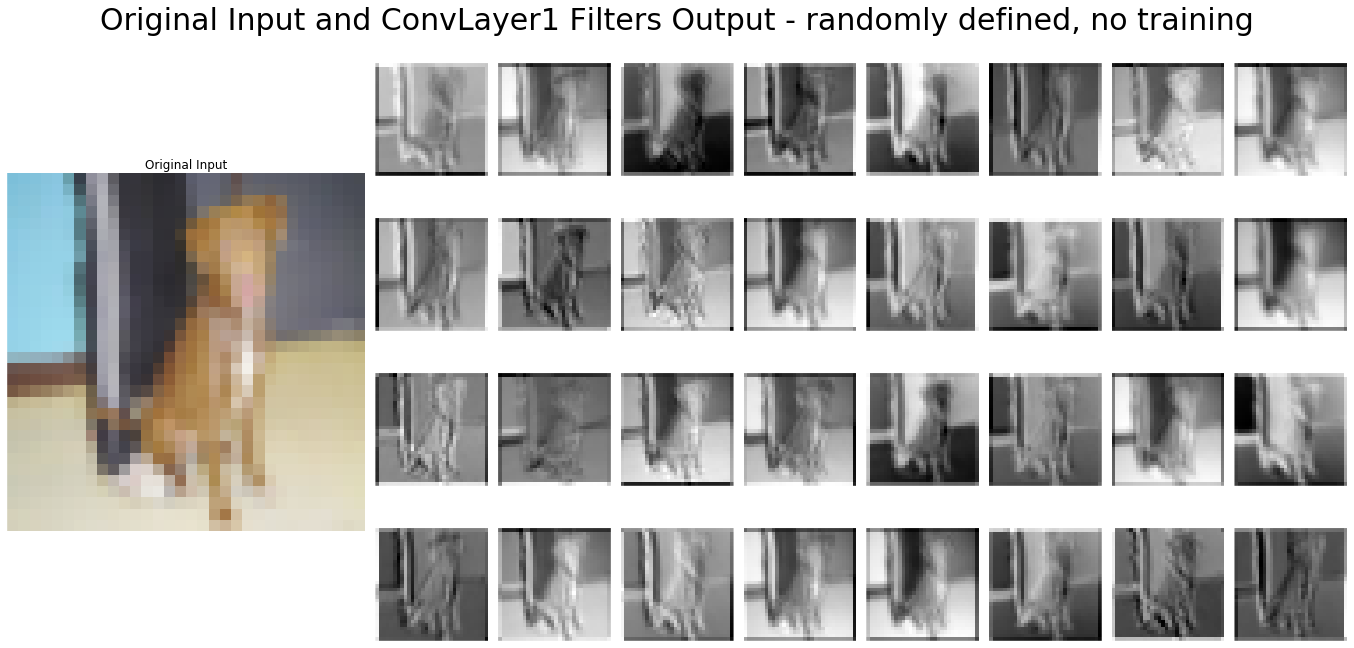

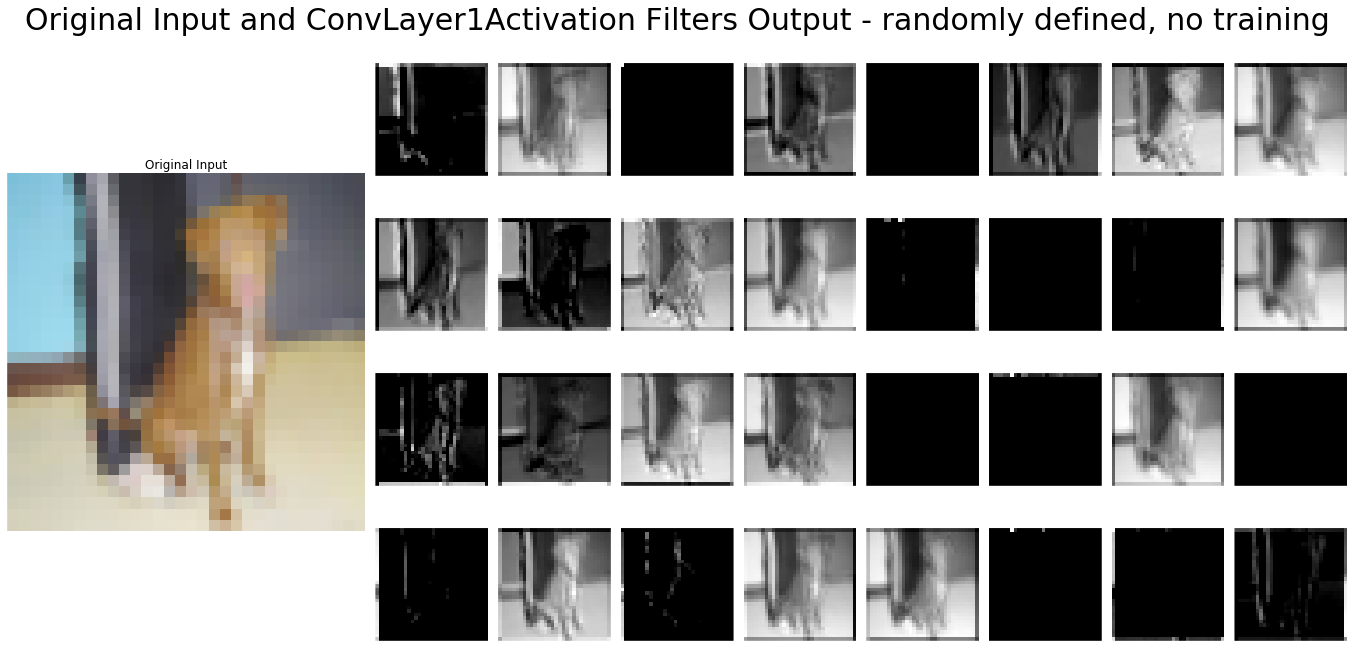

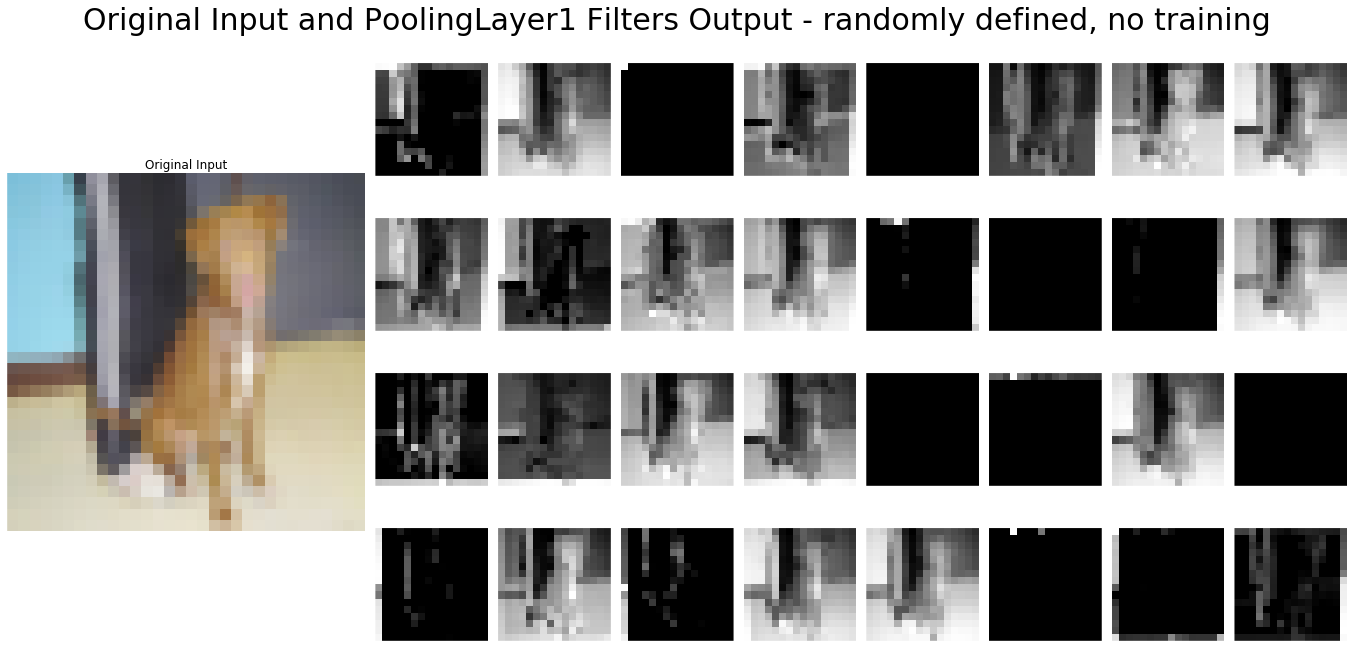

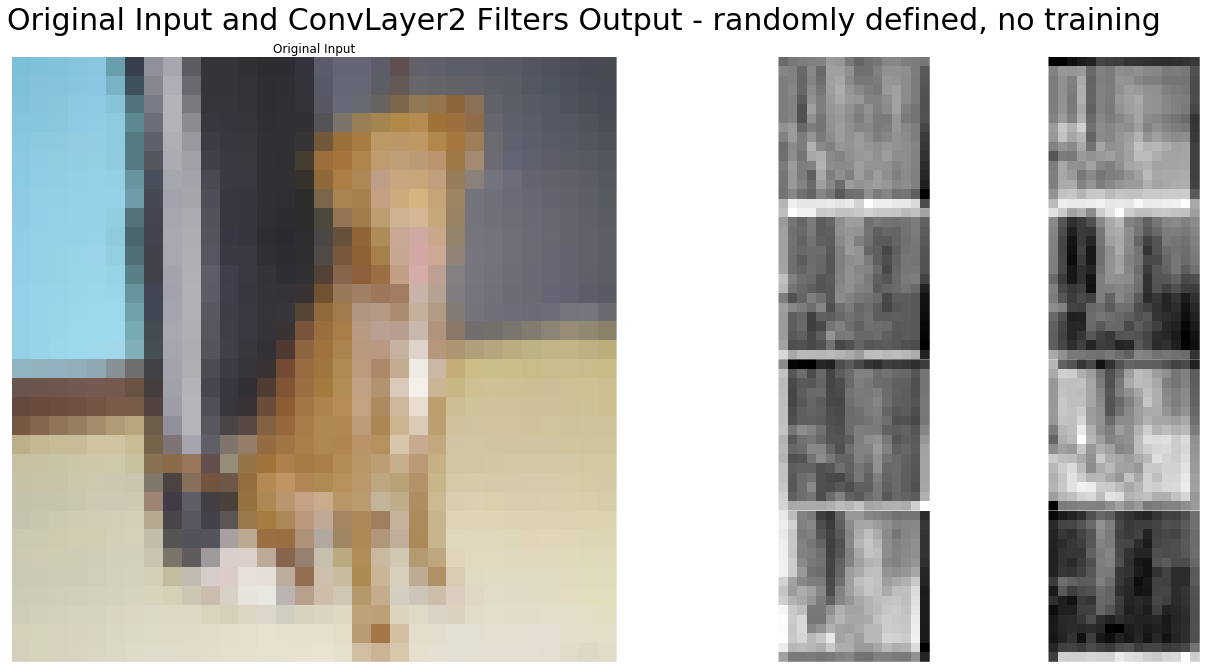

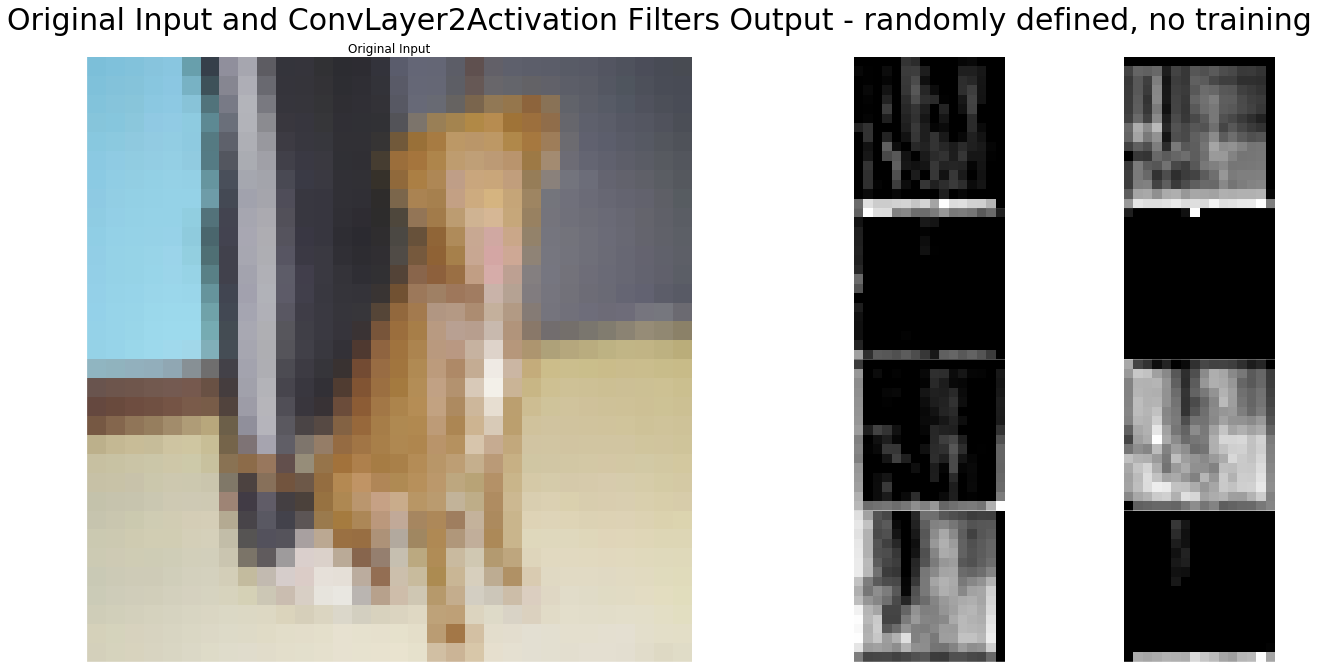

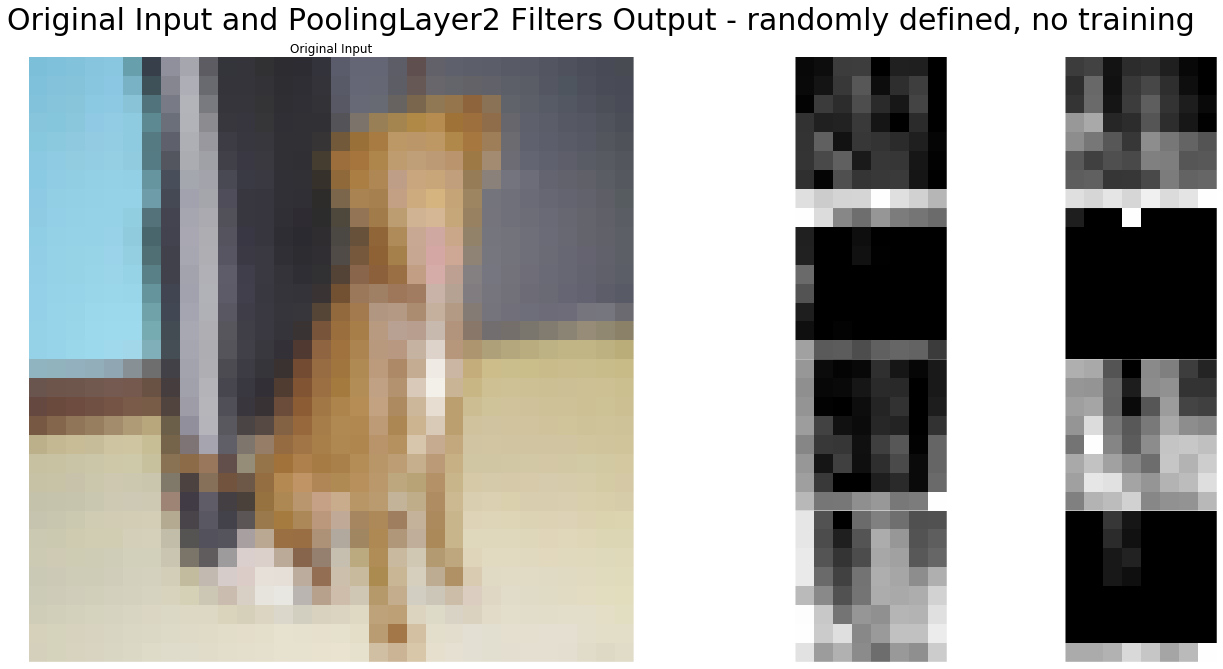

In [180]:
for layer_out,name in zip(intermediate_outputs,intermediate_layer_names):
    plt.figure(figsize=(20,10))
    plt.suptitle("Original Input and " + name + " Filters Output - randomly defined, no training", size=30)

    plt.subplot2grid((4,layer_out.shape[1]/4+3), (0, 0), colspan=3, rowspan=4)
    plt.imshow(numpy.rollaxis(input_image, 0,3), interpolation='none')
    plt.gca().axis('off')
    plt.xticks([],[]) # avoids white spaces
    plt.yticks([],[]) # avoids white spaces
    plt.title("Original Input")
    index = numpy.arange(layer_out.shape[1]).reshape(4,layer_out.shape[1]/4)
    for ri in range(4):
        for ci in range(layer_out.shape[1]/4):
            plt.subplot2grid((4,layer_out.shape[1]/4+3), (ri, 3+ci))
            plt.imshow(layer_out.reshape(layer_out.shape[1],layer_out.shape[2],layer_out.shape[3])[index[ri,ci]],
                       interpolation='none', cmap='gray')
            plt.gca().axis('off')
            plt.xticks([],[]) # avoids white spaces
            plt.yticks([],[]) # avoids white spaces
    plt.tight_layout(pad=5, h_pad=0, w_pad=1, rect=None)
    plt.show()

### Now, let's have a look at the weights:

In [181]:
layer_name = 'ConvLayer1'
weights_random_conv1 = numpy.copy(model.get_layer(layer_name).get_weights()[0]) # weights
bias_random_conv1 = numpy.copy(model.get_layer(layer_name).get_weights()[1]) # bias

layer_name = 'ConvLayer2'
weights_random_conv2 = numpy.copy(model.get_layer(layer_name).get_weights()[0]) # weights
bias_random_conv2 = numpy.copy(model.get_layer(layer_name).get_weights()[1]) # bias

In [182]:
weights_random_conv1.shape, bias_random_conv1.shape, weights_random_conv2.shape, bias_random_conv2.shape

((32, 3, 3, 3), (32,), (8, 32, 3, 3), (8,))

## 4) Compile the model, learn and test against the 25% we saved as testing set

In [183]:
%%time
# learning rate=0.01
sgd = SGD(lr=0.01)
model.compile(loss="binary_crossentropy", 
              optimizer=sgd, 
              metrics=["accuracy"])
model.fit(trainData, trainLabels, nb_epoch=1000, batch_size=128, verbose=0)

CPU times: user 1h 14min 35s, sys: 1min 7s, total: 1h 15min 43s
Wall time: 1h 15min 40s


In [184]:
# model.save('my_convnet_SDG.h5')
model = load_model('my_convnet_SDG.h5') # The model was saved!

In [185]:
score = model.evaluate(testData, testLabels, batch_size=128, verbose=0)
print('Test score:', score[0])
print('Test accuracy:', score[1])

('Test score:', 0.15456351254940032)
('Test accuracy:', 0.97056000011444088)


In [186]:
# https://keras.io/getting-started/faq/#how-can-i-obtain-the-output-of-an-intermediate-layer

intermediate_layer_names = ['ConvLayer1','ConvLayer1Activation','PoolingLayer1',
                            'ConvLayer2','ConvLayer2Activation','PoolingLayer2']

intermediate_objects = []

for layer_name in intermediate_layer_names:
    intermediate_objects.append(Model(input=model.input, output=model.get_layer(layer_name).output))
    
idx = 1
input_image = testData[idx]
# The method "predict" would like to receive a list of images, 
# therefore we reshape our image to look like a list of images ;)

intermediate_outputs = []
for layer_object in intermediate_objects:
    intermediate_outputs.append(layer_object.predict(input_image.reshape(1,
                                                                         input_image.shape[0],
                                                                         input_image.shape[1],
                                                                         input_image.shape[2])))

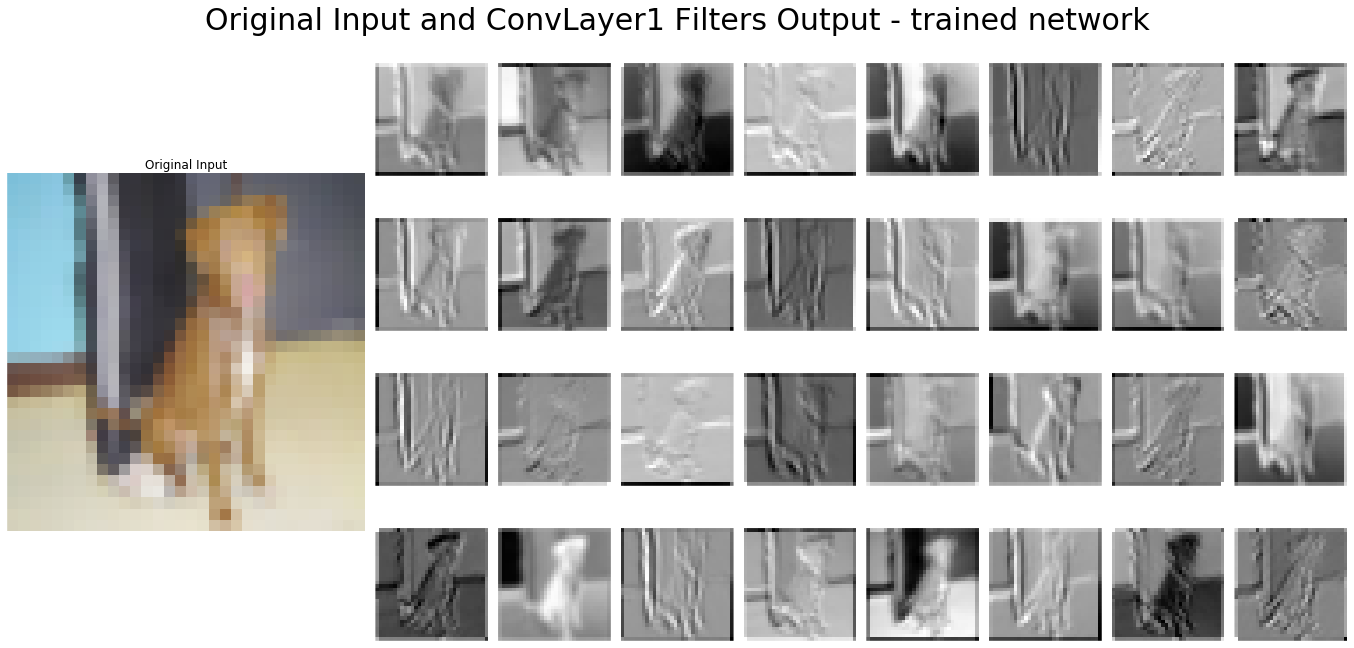

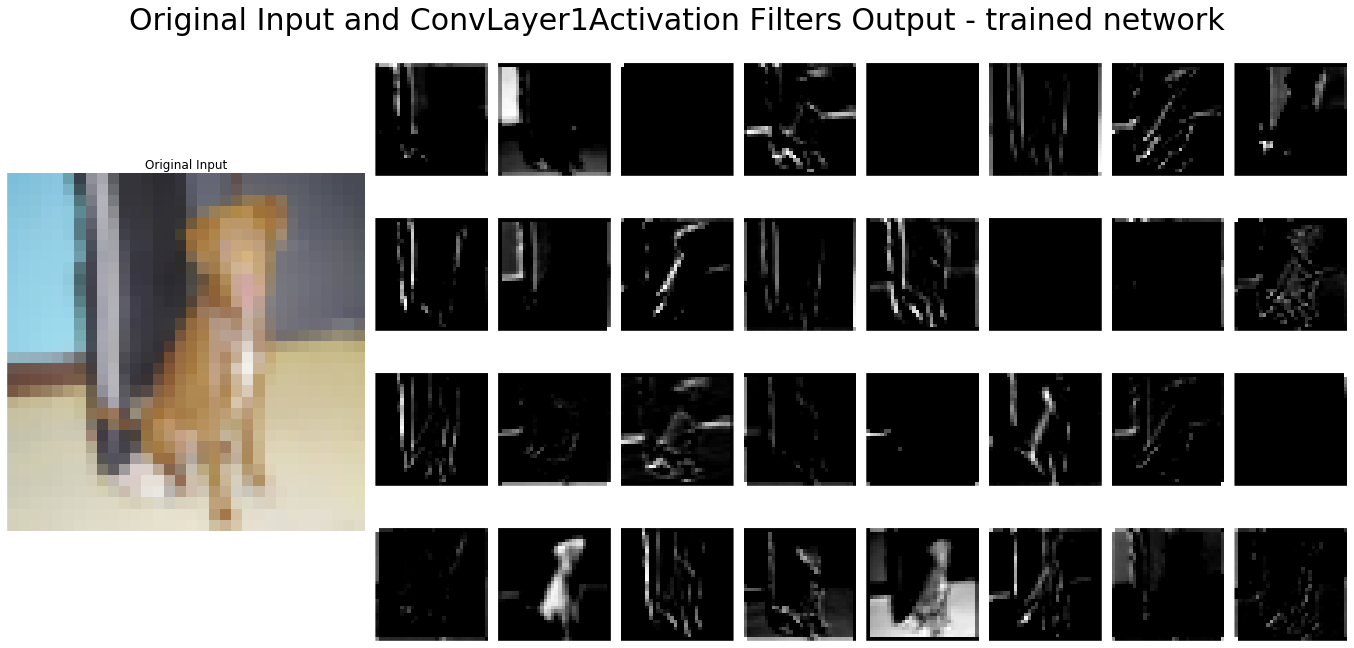

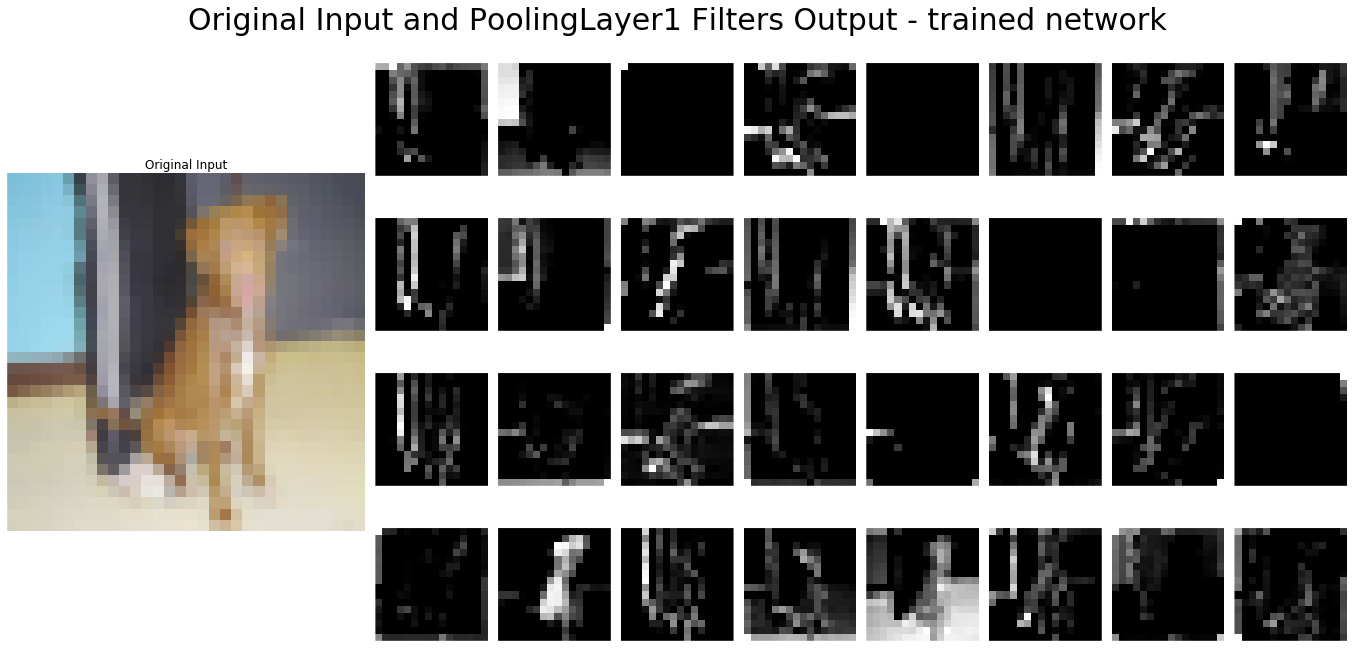

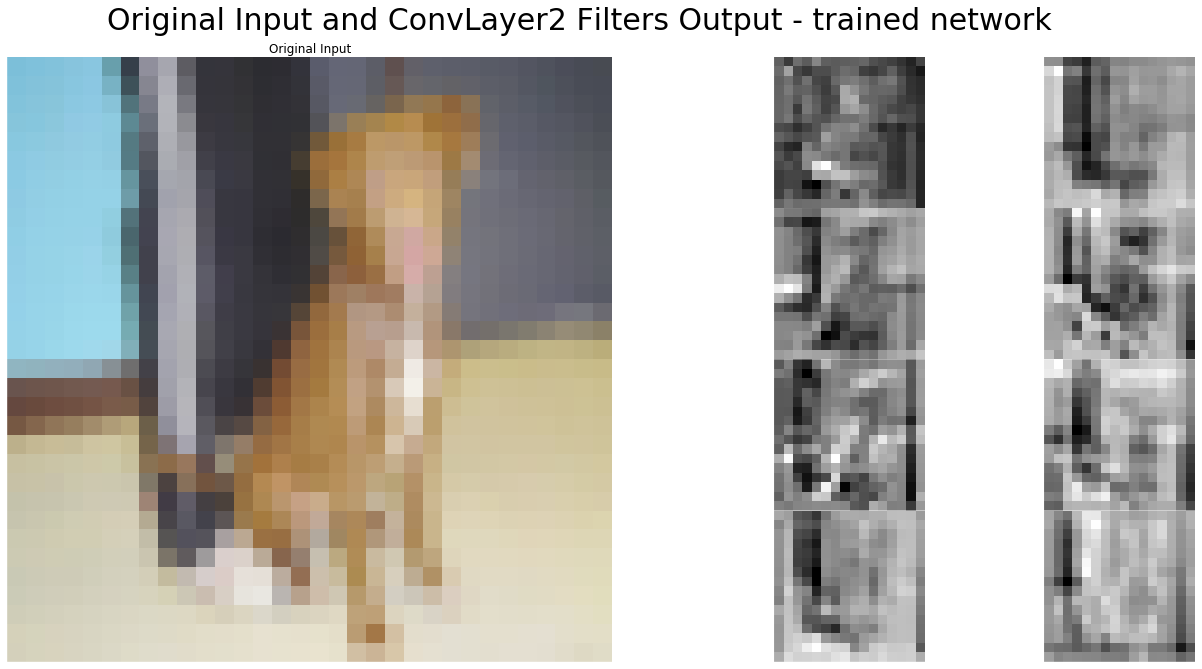

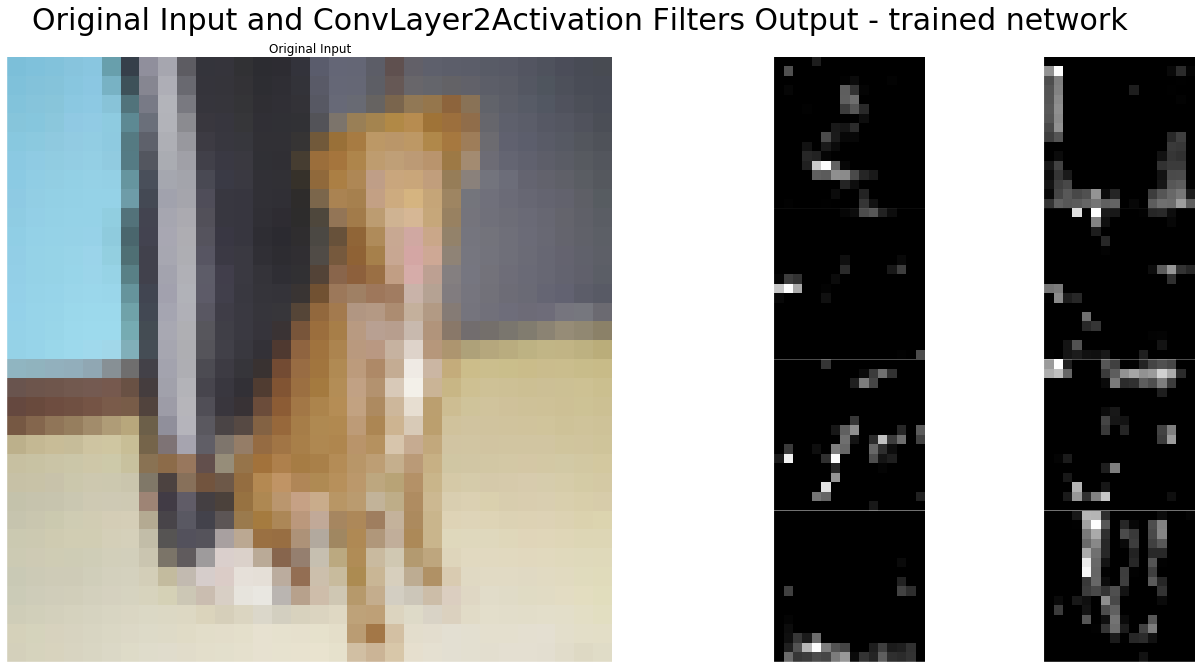

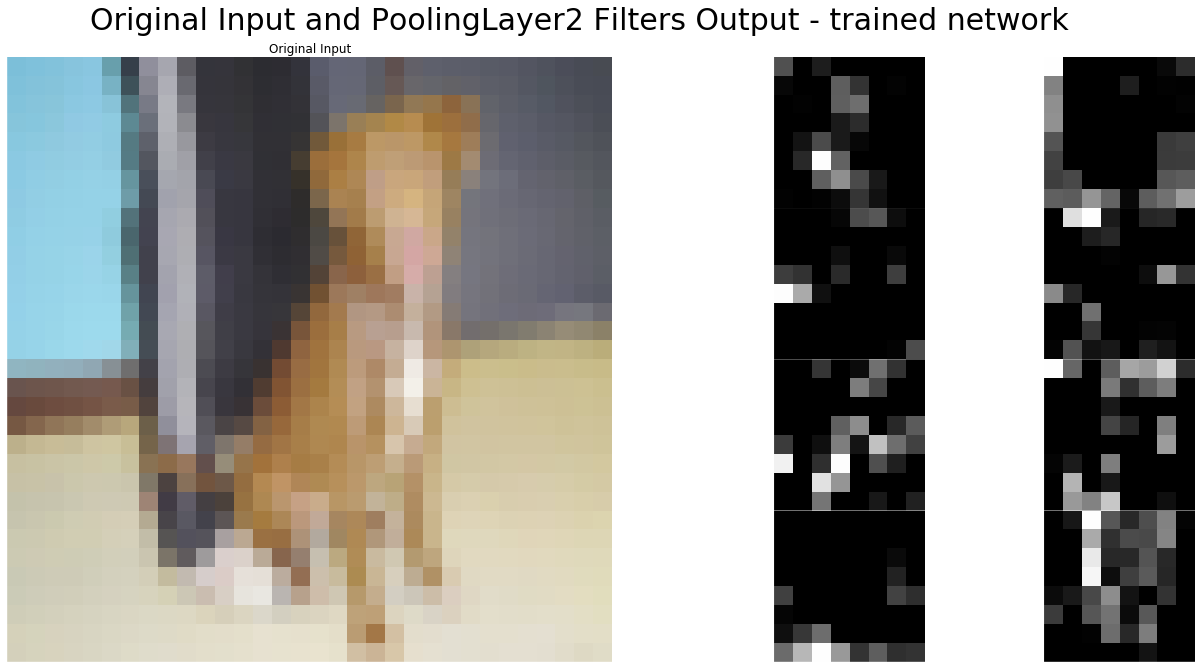

In [187]:
for layer_out,name in zip(intermediate_outputs,intermediate_layer_names):
    plt.figure(figsize=(20,10))
    plt.suptitle("Original Input and " + name + " Filters Output - trained network", size=30)

    plt.subplot2grid((4,layer_out.shape[1]/4+3), (0, 0), colspan=3, rowspan=4)
    plt.imshow(numpy.rollaxis(input_image, 0,3), interpolation='none')
    plt.gca().axis('off')
    plt.xticks([],[]) # avoids white spaces
    plt.yticks([],[]) # avoids white spaces
    plt.title("Original Input")
    index = numpy.arange(layer_out.shape[1]).reshape(4,layer_out.shape[1]/4)
    for ri in range(4):
        for ci in range(layer_out.shape[1]/4):
            plt.subplot2grid((4,layer_out.shape[1]/4+3), (ri, 3+ci))
            plt.imshow(layer_out.reshape(layer_out.shape[1],layer_out.shape[2],layer_out.shape[3])[index[ri,ci]],
                       interpolation='none', cmap='gray')
            plt.gca().axis('off')
            plt.xticks([],[]) # avoids white spaces
            plt.yticks([],[]) # avoids white spaces
    plt.tight_layout(pad=5, h_pad=0, w_pad=1, rect=None)
    plt.show()

In [189]:
# https://keras.io/getting-started/faq/#how-can-i-obtain-the-output-of-an-intermediate-layer

intermediate_layer_names = ['ConvLayer1','ConvLayer1Activation','PoolingLayer1',
                            'ConvLayer2','ConvLayer2Activation','PoolingLayer2']

intermediate_objects = []

for layer_name in intermediate_layer_names:
    intermediate_objects.append(Model(input=model.input, output=model.get_layer(layer_name).output))
    
idx = 2
input_image = testData[idx]
# The method "predict" would like to receive a list of images, 
# therefore we reshape our image to look like a list of images ;)

intermediate_outputs = []
for layer_object in intermediate_objects:
    intermediate_outputs.append(layer_object.predict(input_image.reshape(1,
                                                                         input_image.shape[0],
                                                                         input_image.shape[1],
                                                                         input_image.shape[2])))

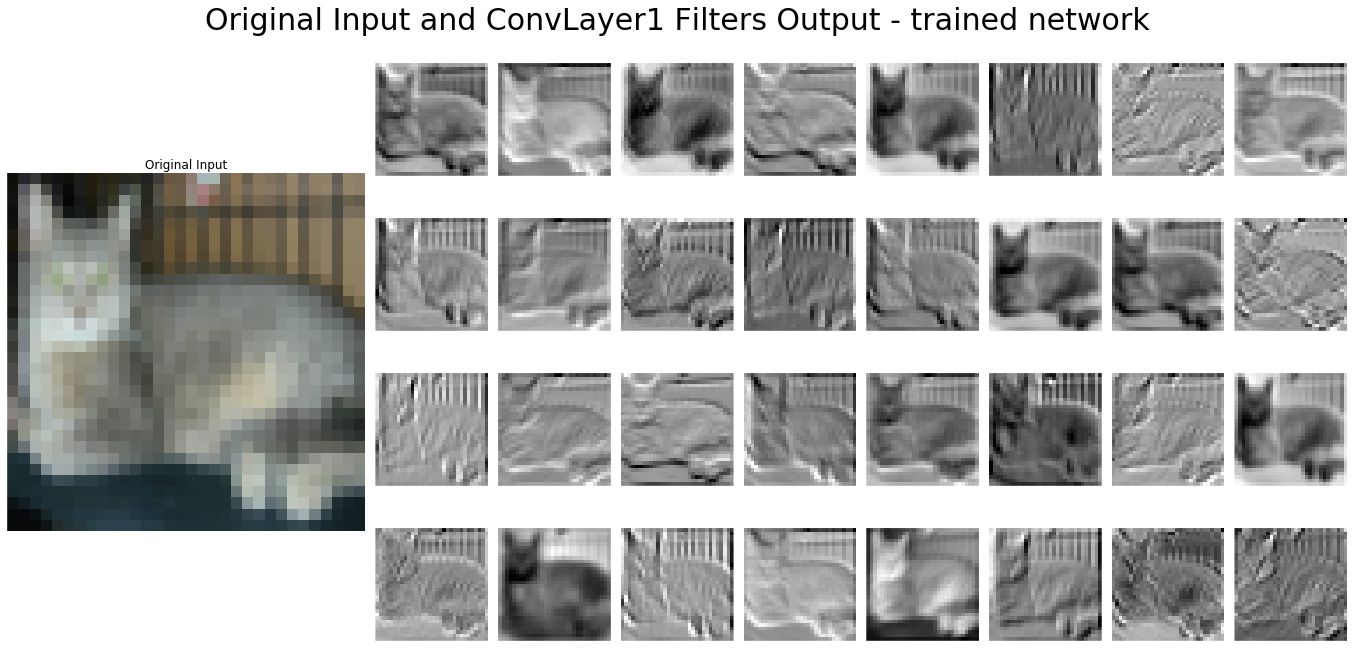

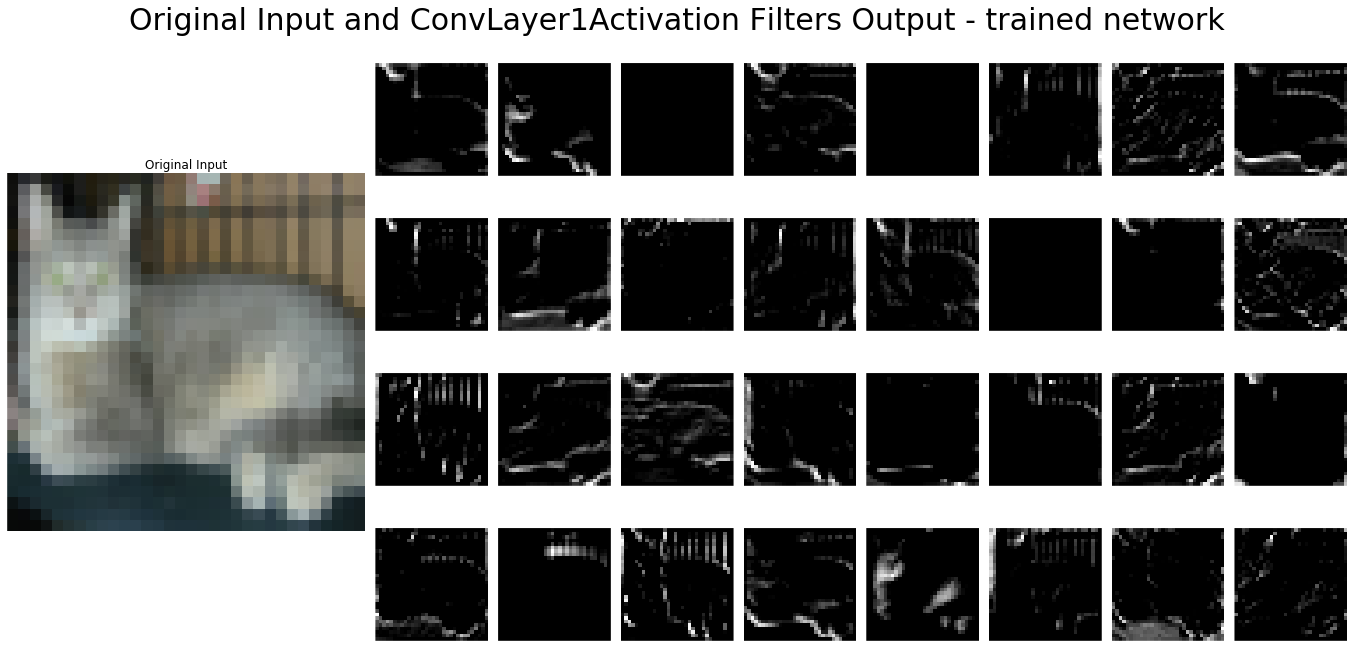

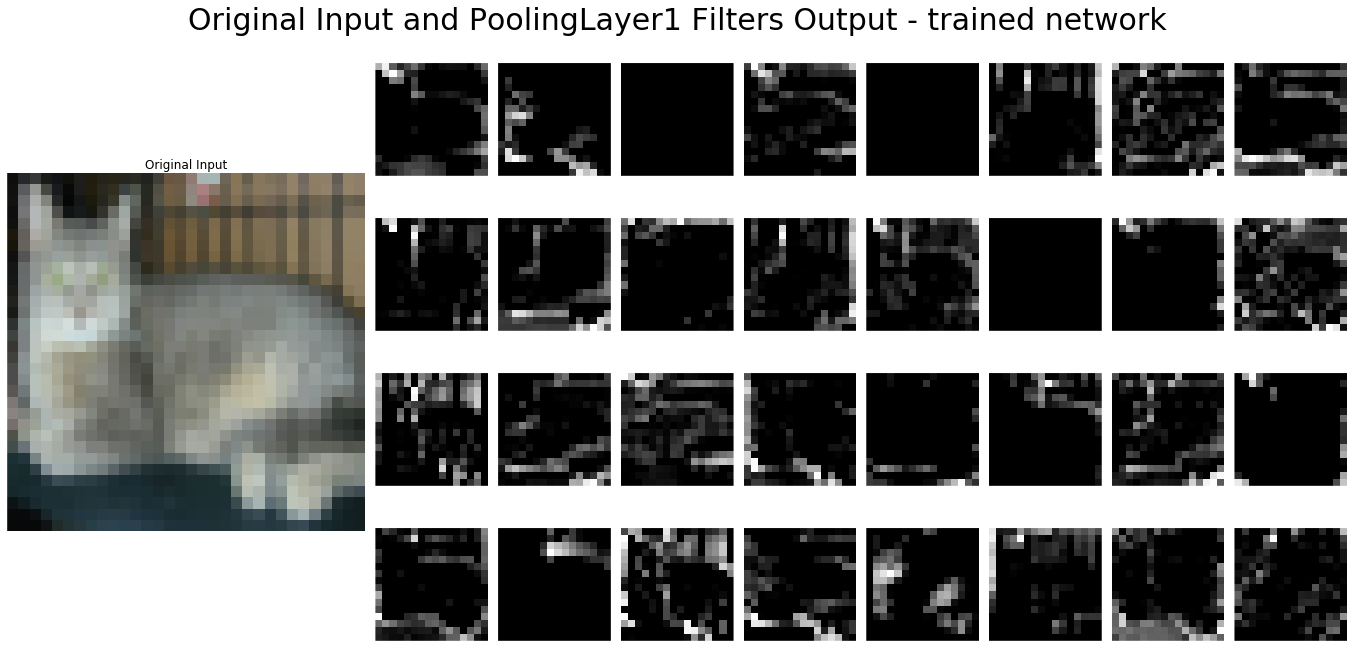

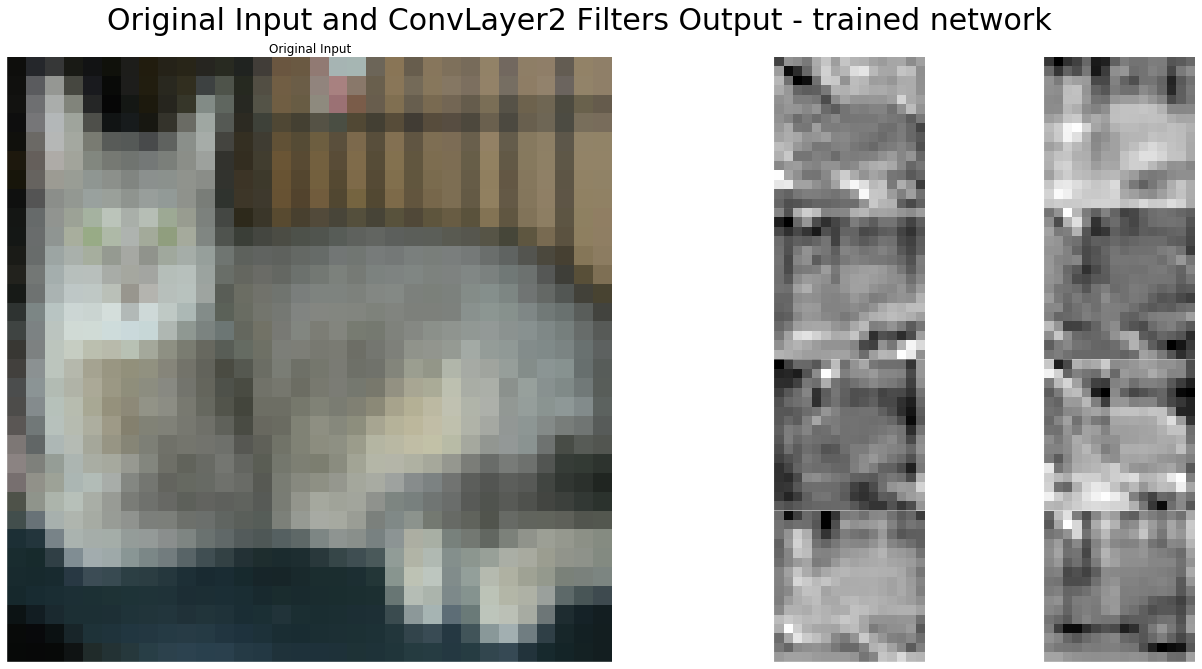

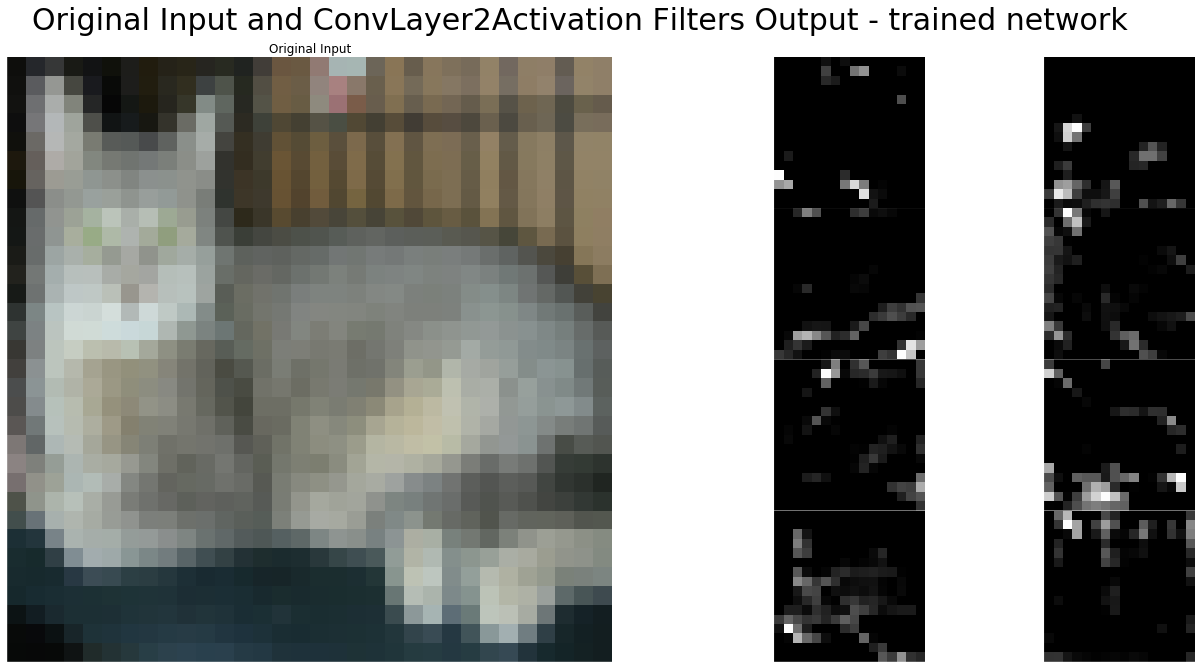

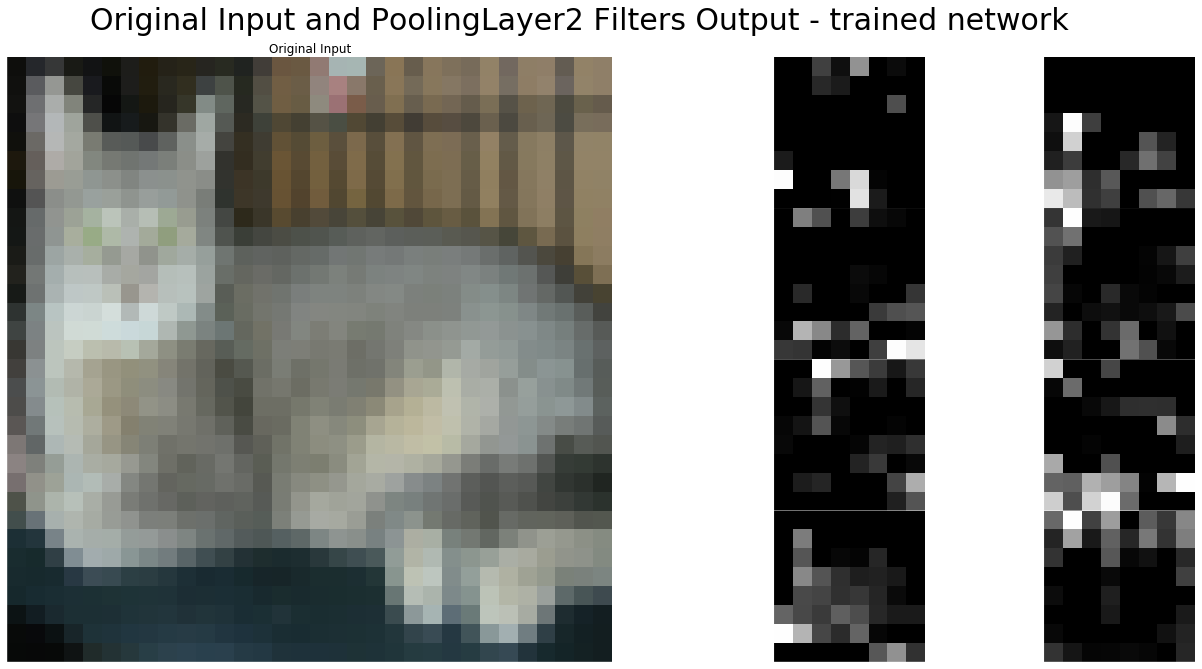

In [190]:
for layer_out,name in zip(intermediate_outputs,intermediate_layer_names):
    plt.figure(figsize=(20,10))
    plt.suptitle("Original Input and " + name + " Filters Output - trained network", size=30)

    plt.subplot2grid((4,layer_out.shape[1]/4+3), (0, 0), colspan=3, rowspan=4)
    plt.imshow(numpy.rollaxis(input_image, 0,3), interpolation='none')
    plt.gca().axis('off')
    plt.xticks([],[]) # avoids white spaces
    plt.yticks([],[]) # avoids white spaces
    plt.title("Original Input")
    index = numpy.arange(layer_out.shape[1]).reshape(4,layer_out.shape[1]/4)
    for ri in range(4):
        for ci in range(layer_out.shape[1]/4):
            plt.subplot2grid((4,layer_out.shape[1]/4+3), (ri, 3+ci))
            plt.imshow(layer_out.reshape(layer_out.shape[1],layer_out.shape[2],layer_out.shape[3])[index[ri,ci]],
                       interpolation='none', cmap='gray')
            plt.gca().axis('off')
            plt.xticks([],[]) # avoids white spaces
            plt.yticks([],[]) # avoids white spaces
    plt.tight_layout(pad=5, h_pad=0, w_pad=1, rect=None)
    plt.show()

## Testing the weights to check what Keras is doing

In [191]:
layer_name = 'ConvLayer1'
weights_conv1 = numpy.copy(model.get_layer(layer_name).get_weights()[0]) # weights
bias_conv1 = numpy.copy(model.get_layer(layer_name).get_weights()[1]) # bias

layer_name = 'ConvLayer2'
weights_conv2 = numpy.copy(model.get_layer(layer_name).get_weights()[0]) # weights
bias_conv2 = numpy.copy(model.get_layer(layer_name).get_weights()[1]) # bias

In [229]:
weights_conv2.shape,bias_conv2.shape

### Convolution

In [192]:
idx = 1
input_image = testData[idx]

result = []

for i in range(3):
    result.append(convolve2d(input_image[i],
                             weights_conv1[0][i],
                             mode='same',
                             boundary='fill'))
result = numpy.array(result)

In [230]:
result.shape

In [193]:
final_img_weights = result.sum(axis=0)+bias_conv1[0]
final_img_convlayer = ConvLayer1_out_output.reshape(32,32,32)[0]

In [231]:
final_img_weights.shape, final_img_convlayer.shape

In [195]:
final_img_weights.max(),final_img_weights.min(),final_img_convlayer.max(),final_img_convlayer.min()

(0.66245410693421325, -1.9792279362021121, -0.10236336, -0.67213947)

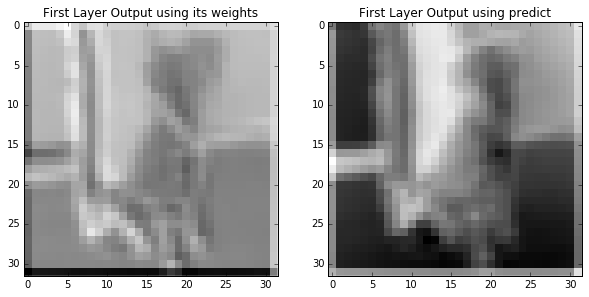

In [196]:
#
# The figures below show Keras is really doing a convolution and not a cross-correlation
#
plt.figure(figsize=(10,10))
plt.subplot(121)
plt.imshow(final_img_weights,interpolation='none',cmap='gray')
plt.title("First Layer Output using its weights")

plt.subplot(122)
plt.imshow(final_img_convlayer,interpolation='none',cmap='gray')
plt.title("First Layer Output using predict")
plt.show()

### Correlation

In [197]:
# http://stackoverflow.com/questions/20077378/python-scipy-convolve2d-seems-incorrect
from scipy.ndimage import correlate
from scipy.signal import correlate2d

In [198]:
weights_conv1[0][0], numpy.fliplr(weights_conv1[0][0])

(array([[  1.44997299e-01,   9.15070414e-05,  -9.17081535e-02],
        [ -4.39581573e-01,  -2.04413056e-01,  -1.77449137e-01],
        [ -8.15098509e-02,  -2.30662182e-01,  -3.47554535e-02]], dtype=float32),
 array([[ -9.17081535e-02,   9.15070414e-05,   1.44997299e-01],
        [ -1.77449137e-01,  -2.04413056e-01,  -4.39581573e-01],
        [ -3.47554535e-02,  -2.30662182e-01,  -8.15098509e-02]], dtype=float32))

In [199]:
idx = 1
input_image = testData[idx]

result = []

for i in range(3):
    result.append(correlate2d(input_image[i],
                              weights_conv1[0][i], mode='same'))
result = numpy.array(result)

In [200]:
final_img_weights = result.sum(axis=0)+bias_conv1[0]
final_img_convlayer = ConvLayer1_out_output.reshape(32,32,32)[0]

In [201]:
final_img_weights.max(),final_img_weights.min(),final_img_convlayer.max(),final_img_convlayer.min()

(0.57107687212193536, -1.4179187430726254, -0.10236336, -0.67213947)

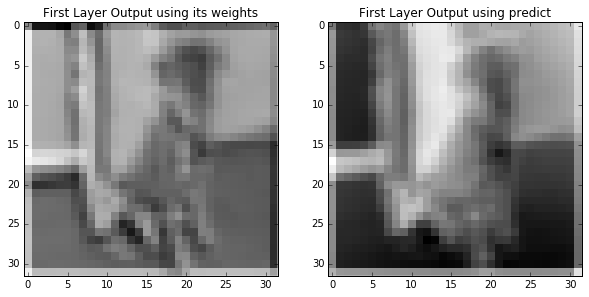

In [202]:
plt.figure(figsize=(10,10))
plt.subplot(121)
plt.imshow(final_img_weights,interpolation='none',cmap='gray')
plt.title("First Layer Output using its weights")

plt.subplot(122)
plt.imshow(final_img_convlayer,interpolation='none',cmap='gray')
plt.title("First Layer Output using predict")

plt.show()

## However, a correlation is "almost" the same thing as convolution. If you flip your kernel, you can go from one to another:

In [203]:
idx = 1
input_image = testData[idx]

result = []

for i in range(3):
    result.append(correlate2d(input_image[i],
                            numpy.fliplr(numpy.flipud(weights_conv1[0][i])), mode='same'))
result = numpy.array(result)

In [204]:
final_img_weights = result.sum(axis=0)+bias_conv1[0]
final_img_convlayer = ConvLayer1_out_output.reshape(32,32,32)[0]

In [205]:
final_img_weights.max(),final_img_weights.min(),final_img_convlayer.max(),final_img_convlayer.min()

(0.66245410693421325, -1.9792279362021121, -0.10236336, -0.67213947)

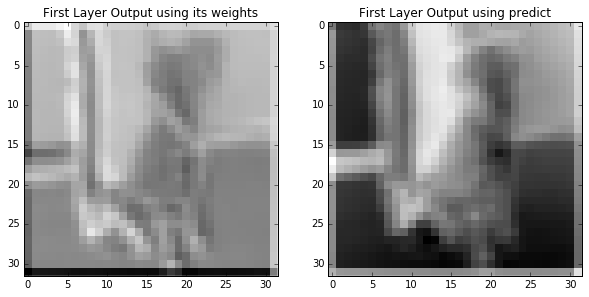

In [206]:
plt.figure(figsize=(10,10))
plt.subplot(121)
plt.imshow(final_img_weights,interpolation='none',cmap='gray')
plt.title("First Layer Output using its weights")

plt.subplot(122)
plt.imshow(final_img_convlayer,interpolation='none',cmap='gray')
plt.title("First Layer Output using predict")

plt.show()

## Testing using the test1 directory
### Images the neural network has never seen before
But first we need to load and prepare the images

In [207]:
# Returns the current working directory
# (where the Python interpreter was called)
path = os.getcwd()

# The path separator used by the OS:
sep = os.path.sep

# This is the directory where the training images are located
dirname = "test1"

# Generates a list of all images (actualy the filenames) from the training set,
# but it will also include the full path
imagePaths = [path+sep+dirname+sep+filename 
                  for filename in os.listdir(path+sep+dirname)]

In [208]:
%%time
ans = Pool(number_of_parallel_processes).map(import_training_set,[(i,img,new_image_size) 
                                                                  for i,img in enumerate(imagePaths)])

CPU times: user 122 ms, sys: 76.5 ms, total: 199 ms
Wall time: 20.1 s


In [209]:
testing_set = dict(ans)
del ans # this is just to help saving memory...

### Selects a random image

In [210]:
idx = numpy.random.randint(0,len(testing_set))
X = testing_set[idx][-1].reshape(1,testing_set[idx][-1].shape[0],
                                   testing_set[idx][-1].shape[1],
                                   testing_set[idx][-1].shape[2])/255.0 # /255.0=>normalisation!

In [211]:
# [1.,0.]=>Dog
# [0.,1.]=>Cat
pred = model.predict(X)
if pred[0,0]>pred[0,1]:
    print("Dog! [{},{}]".format(pred[0,0],pred[0,1]))
else:
    print("Cat! [{},{}]".format(pred[0,0],pred[0,1]))

Cat! [0.409717589617,0.590282440186]


In [212]:
X.shape

(1, 3, 32, 32)

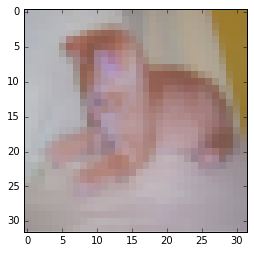

In [213]:
img = numpy.rollaxis(X.reshape((3,32,32)),0,3)
plt.imshow(img,interpolation='none')
plt.show()

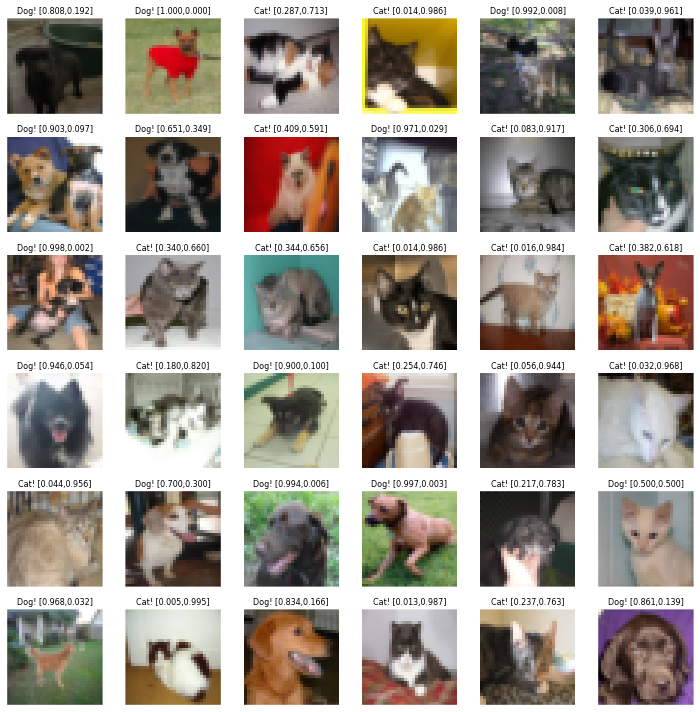

In [227]:
plt.figure(figsize=(10,10))
for i in range(36):
    # Randomly selects one image from our test set (same used for error calculation)
    idx = numpy.random.randint(0,len(testing_set))
    X = testing_set[idx][-1].reshape(1,testing_set[idx][-1].shape[0],
                                       testing_set[idx][-1].shape[1],
                                       testing_set[idx][-1].shape[2])/255.0 # /255.0=>normalisation!

    # [1.,0.]=>Dog
    # [0.,1.]=>Cat
    pred = model.predict(X)
    if pred[0,0]>pred[0,1]:
        title = "Dog! [{:.3f},{:.3f}]".format(pred[0,0],pred[0,1])
    else:
        title = "Cat! [{:.3f},{:.3f}]".format(pred[0,0],pred[0,1])

    # Visualization
    # But remember, the network 'eats' images reshaped as 1D vectors
    img = numpy.rollaxis(X.reshape((3,32,32)),0,3)
    plt.subplot2grid((6,6),(i/6,i%6))
    plt.imshow(img,interpolation='none')
    plt.title(title, fontdict={'fontsize': 8})
    plt.axis('off')
    plt.xticks([],[]) # avoids white spaces
    plt.yticks([],[]) # avoids white spaces
plt.tight_layout()
plt.show()

## Loading an image from a URL

In [215]:
def get_img_from_url(url):
    # http://stackoverflow.com/a/7391991
    file = cStringIO.StringIO(urllib.urlopen(url).read())
    return scipy.misc.imread(file)

In [216]:
dog_url = "https://cdn.pixabay.com/photo/2016/02/19/15/46/dog-1210559_960_720.jpg"
cat_url = "https://cdn.pixabay.com/photo/2014/03/29/09/17/cat-300572_960_720.jpg"

Dog! [0.999988794327,1.11491754069e-05]


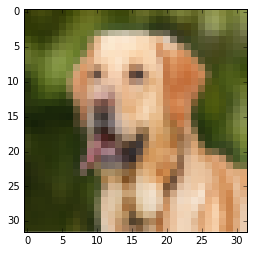

In [217]:
image = get_img_from_url(dog_url)

X = numpy.rollaxis(scipy.misc.imresize(image,(32,32)),2,0)/255.0 # /255.0=>normalisation!

# [1.,0.]=>Dog
# [0.,1.]=>Cat
pred = model.predict(X.reshape((1,X.shape[0],X.shape[1],X.shape[2])))
if pred[0,0]>pred[0,1]:
    print("Dog! [{},{}]".format(pred[0,0],pred[0,1]))
else:
    print("Cat! [{},{}]".format(pred[0,0],pred[0,1]))
    
img = numpy.rollaxis(X.reshape((3,32,32)),0,3)
plt.imshow(img,interpolation='none')
plt.show()

Cat! [0.461482644081,0.538517355919]


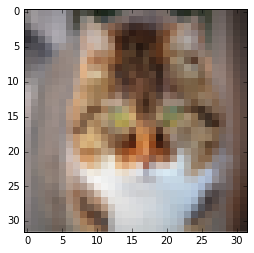

In [218]:
image = get_img_from_url(cat_url)

X = numpy.rollaxis(scipy.misc.imresize(image,(32,32)),2,0)/255.0 # /255.0=>normalisation!

# [1.,0.]=>Dog
# [0.,1.]=>Cat
pred = model.predict(X.reshape((1,X.shape[0],X.shape[1],X.shape[2])))
if pred[0,0]>pred[0,1]:
    print("Dog! [{},{}]".format(pred[0,0],pred[0,1]))
else:
    print("Cat! [{},{}]".format(pred[0,0],pred[0,1]))
    
img = numpy.rollaxis(X.reshape((3,32,32)),0,3)
plt.imshow(img,interpolation='none')
plt.show()

In [221]:
# Using sympy to print nice LaTeX based matrices:
# http://docs.sympy.org/dev/tutorial/printing.html
import sympy #Matrix, init_printing
# init_printing(use_latex=True)
sympy.init_printing(use_latex='png')  # Makes easier to add to a post without using MathML

In [222]:
weights_conv1.shape, weights_random_conv1.shape

In [223]:
weights_conv1[0].shape, weights_random_conv1[0].shape

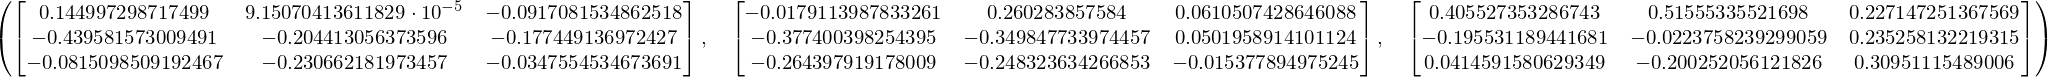

In [225]:
sympy.Matrix(weights_conv1[0][0]),sympy.Matrix(weights_conv1[0][1]),sympy.Matrix(weights_conv1[0][2])

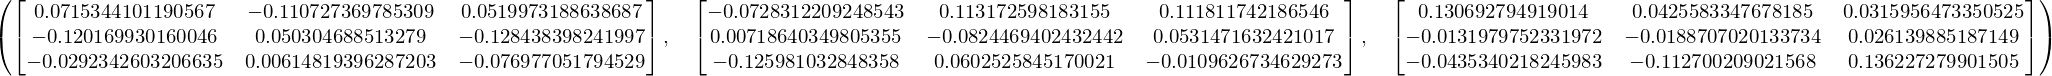

In [226]:
sympy.Matrix(weights_random_conv1[0][0]),sympy.Matrix(weights_random_conv1[0][1]),sympy.Matrix(weights_random_conv1[0][2])